# Voice of Customer Analytics

Topic Modeling

## Importing libraries and data

In [ ]:
!pip install pythainlp
!pip install tensorflow_text
!pip install umap-learn
!pip install deepcut


In [ ]:
import pythainlp
import gensim

import numpy as np
import pandas as pd
import re
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import umap.umap_ as umap
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from pythainlp.corpus.common import thai_words
from pythainlp.util import Trie
import collections
import deepcut

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
# ข้อมูลแสดงข้อความที่ถูกพูดถึงใน Social ด้านเศรษฐกิจ (Economy) ปี 2564
df = pd.read_csv('/content/dataload2.csv')
df.tail()

,id,sentence,like_count,near,geo,published_timestamp,sentiment,sentiment_score,source_type,topic,processed_sentence
94,wj4amEkZ4PI,ชีวิตของแม่ ขึ้นอยู่กับลูก? | Highlight Ep.26 ...,144,NaN,NaN,2023-07-03T13:00:52Z,NEUTRAL,0.987165,youtube_video,economy.employment,ชีวิต แม่ ขึ้นอยู่กับ ลูก Highlight Ep 26 ดอก ...
95,wHk7b2OnhZo,วิธีสมัครงานโรงแรมคาสิโนมาเก๊าอย่างละเอียด 202...,5,NaN,NaN,2023-07-01T04:10:38Z,NEUTRAL,0.993337,youtube_video,economy.employment,วิธี สมัครงาน โรงแรม คาสิโน มาเก๊า ละเอียด 202...
96,WE3xxrykGQE,เวลาที่ชาว Bitcoiner รอคอยมาถึงแล้ว? หลังจากผ่...,140,NaN,NaN,2023-07-06T00:00:13Z,NEUTRAL,0.991666,youtube_video,economy.finance,เวลา Bitcoiner รอคอย มาถึง สถานการณ์ Downtrend...
97,WBZ2WtJ3C4o,คลิปสุดท้ายที่เกาหลี🇰🇷 ลูกครึ่งไทยญี่ปุ่น #ครอ...,180,NaN,NaN,2023-07-02T15:41:07Z,NEUTRAL,0.955922,youtube_video,economy.tourism,คลิป สุดท้าย เกาหลี 🇰🇷 ลูกครึ่ง ไทย ญี่ปุ่น คร...
98,wBG3NlNQE_g,2Y25 HONDA CR V 2 0 E 4WD โฉมปี 12 17 2014 เต็...,0,NaN,NaN,2023-07-01T08:15:21Z,NEUTRAL,0.821401,youtube_video,economy.finance,25 HONDA CR WD โฉม ปี 12 17 2014 เต็นท์ รถ ยอด...


In [ ]:
# สร้างไฟล์ CSV จาก DataFrame
#df.to_csv('dataload.csv', index=False , encoding='utf-8-sig')


In [ ]:
stopwords = list(pythainlp.corpus.thai_stopwords())
removed_words = [' ','  ','\n','(',')','ไทย','ชีวิต','เวลา','ค่ะ','คะ','ๆ','มี','และ','ชีวิต.','สมัครงาน','ๆๆ','ค่','-','ประวัติศาสตร์','ปี','คาสิโน','แม่','นั่ง','คลิป']
screening_words = stopwords + removed_words

existing_words = set(thai_words())
words = {'อุตสาหกรรม','ท่องเที่ยว','เรียนรู้','สงบ','ชุมชน','รัฐบาล','วิสัยทัศน์','รถส่วนตัว','ผู้ประกอบการ','ตำแหน่ง','ข่าว','อีกรอบ','ผู้เชี่ยวชาญ','อพำนวย','สงบดี','วิเคราะห์','คา'}
custom_dict = existing_words.union(words)

custom_dictionary_trie = Trie(custom_dict)

def tokenize_with_comma(sentence):
  merged = ''
  words = pythainlp.word_tokenize(str(sentence), engine = 'newmm',custom_dict = custom_dictionary_trie)
  print(words)
  for word in words:
    if word not in screening_words:
      merged = merged + ',' + word
  return merged[1:]

In [ ]:
df['processed_sentence'] = df['sentence'].apply(lambda x: tokenize_with_comma(x))
df.head()

['FM', ' ', '96.5', ' ', '|', ' ', 'ข่าว', 'เด่น', ' ', 'ประเด็น', 'ร้อน', ' ', 'ช่วง', ' ', 'Econ', ' ', 'plus', ' ', '|', ' ', 'หุ้น', 'ไทย', 'ตกลง', ' ', '100', 'จุด', ' ', '|', ' ', '30', ' ', 'มิ.ย.', ' ', '66', ' ', 'รายการ', ' ', '#', 'ข่าว', 'เด่น', ' ', 'ประเด็น', 'ร้อน', ' ', '#', 'ThinkingRadio', ' ', 'ติดตาม', 'ได้', 'ทุกวัน', 'จันทร์', '-', 'ศุกร์', ' ', '⏰', 'เวลา', ' ', '18.00', ' ', '–', ' ', '19.30', ' ', 'น.']
['สรุป', 'ข่าว', 'แมน', 'ยู', ' ', 'ล่าสุด', ' ', '1', ' ', 'ก.ค.', ' ', '66', ' ', 'เวลา', ' ', '08.30', ' ', 'น.', ' ', '-', ' ', 'เท', 'น', 'ฮา', 'ก', 'เร่ง', 'ขาย', '!', ' ', 'ดึง', 'บิ', 'จ', 'โลว์', '(', 'ประตู', ')', ' ', 'โอ', 'เซ็มฯ', 'ถูก', 'เสนอ', '?', ' ', 'ขาย', '?', ' ', 'สรุป', 'ข่าว', 'แมน', 'ยู', ' ', 'ล่าสุด', ' ', '1', ' ', 'ก.ค.', ' ', '66', ' ', 'เวลา', ' ', '08.30', ' ', 'น.', ' ', '-', ' ', 'เท', 'น', 'ฮา', 'ก', 'เร่ง', 'ขาย', '!', ' ', 'ดึง', 'บิ', 'จ', 'โลว์', '(', 'ประตู', ')', ' ', 'โอ', 'เซ็มฯ', 'ถูก', 'เสนอ', '?', ' ', 'ขาย', '?', ' 

,id,sentence,like_count,near,geo,published_timestamp,sentiment,sentiment_score,source_type,topic,processed_sentence
0,zzsDOceFRpA,FM 96.5 | ข่าวเด่น ประเด็นร้อน ช่วง Econ plus ...,8,NaN,NaN,2023-07-01T00:32:45Z,NEUTRAL,0.987861,youtube_video,economy.finance,"FM,96.5,|,ข่าว,เด่น,ประเด็น,ร้อน,Econ,plus,|,ห..."
1,ZyfhxEH3Bn4,สรุปข่าวแมนยู ล่าสุด 1 ก.ค. 66 เวลา 08.30 น. -...,1984,NaN,NaN,2023-07-01T03:36:25Z,NEUTRAL,0.994436,youtube_video,economy.finance,"สรุป,ข่าว,แมน,ยู,1,ก.ค.,66,08.30,น.,เท,น,ฮา,ก,..."
2,zy3AVB9nS3E,ชัชชาติ สั่งการทุกเขต ! ตรวจสอบผับ เปิดร้านอาห...,6,NaN,NaN,2023-07-02T15:08:00Z,NEUTRAL,0.905357,youtube_video,economy.food,"ชัชชาติ,สั่งการ,เขต,!,ตรวจสอบ,ผับ,ร้านอาหาร,บั..."
3,zXK4WbwNiU8,ຂ່າວພາກຄໍ່າ [30-06-2023] ຂ່າວພາກຄໍ່າ [30-06-...,15,NaN,NaN,2023-07-01T00:32:56Z,NEUTRAL,0.985426,youtube_video,economy.retail,"ຂ່າວພາກຄໍ່າ, ,[,30,06,2023,],ຂ່າວພາກຄໍ່າ,[,3..."
4,ZxiQchqn8SY,Highlight : อนาคตของสหภาพยุโรป!! รศ.ดร.สมชาย ภ...,235,NaN,NaN,2023-07-05T03:25:26Z,NEUTRAL,0.954594,youtube_video,economy.finance,"Highlight,:,อนาคต,สหภาพ,ยุโรป,!!,รศ.ดร.,สม,ชาย..."


In [ ]:
documents = df['processed_sentence'].to_list()
texts = [[text for text in doc.split(',')] for doc in documents]
dictionary = gensim.corpora.Dictionary(texts)
print(dictionary.token2id.keys())

dict_keys(['#', '100', '18.00', '19.30', '30', '66', '96.5', 'Econ', 'FM', 'ThinkingRadio', 'plus', '|', 'ข่าว', 'จันทร์', 'จุด', 'ตกลง', 'ติดตาม', 'น.', 'ประเด็น', 'มิ.ย.', 'รายการ', 'ร้อน', 'ศุกร์', 'หุ้น', 'เด่น', '–', '⏰', '!', '...', '08.30', '1', '?', 'ก', 'ก.ค.', 'ขอบคุณ', 'ขาย', 'จ', 'ดึง', 'ทุกท่าน', 'น', 'บิ', 'ประตู', 'ผู้ติดตาม', 'ยู', 'สรุป', 'ฮา', 'เซ็มฯ', 'เท', 'เร่ง', 'เสนอ', 'แมน', 'โลว์', 'โอ', '5', '\xa0', 'กรุงเทพมหานคร', 'คาดโทษ', 'ค่ำ', 'ชัชชาติ', 'ตรวจสอบ', 'บังหน้า', 'บาร์', 'ผับ', 'ยึด', 'ร้านอาหาร', 'สถานบริการ', 'สั่ง', 'สั่งการ', 'เขต', 'แอบแฝง', 'ใบอนุญาต', '   ', '06', '2023', '[', ']', 'ຂ່າວພາກຄໍ່າ', '!!', '.', ':', 'Highlight', 'ชาย', 'ภค', 'ภาสน์', 'ยุโรป', 'รศ.ดร.', 'วิวัฒน์', 'สม', 'สหภาพ', 'อนาคต', '19', '63', 'I', 'STARK', 'TNN', 'WEALTH', 'กรรมการผู้จัดการ', 'งบการเงิน', 'บลจ.', 'ประกิต', 'ปลอม', 'พาร์ทเนอร์', 'วัฒน', 'สิริ', 'หมายเหตุ', 'เกตุ', 'เมอร์ชั่น', 'แกะ', '**', '13000', '15000', '600', '83000', '@', 'Line', 'Ot', 'id', 'maidnanny', 'กึ่ง'

In [ ]:
num_topics = 50
chunksize = 4000
passes = 20
iterations = 50
eval_every = 1

temp = dictionary[0]
id2word = dictionary.id2token

In [ ]:
import gensim
from gensim import models

# Create gensim_corpus
gensim_corpus = [dictionary.doc2bow(text) for text in texts]

n_topics = 3
model = models.LdaModel(corpus=gensim_corpus, num_topics=n_topics, id2word=id2word, chunksize=chunksize, alpha='auto', eta='auto', iterations=iterations, passes=passes, eval_every=eval_every)



In [ ]:
#!pip install pyLDAvis


In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(model, gensim_corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.077475  0.087540       1        1  38.212916
1     -0.123144  0.016494       2        1  36.409893
2      0.045669 -0.104034       3        1  25.377191, topic_info=     Term       Freq      Total Category  logprob  loglift
716   ซ่ง   8.000000   8.000000  Default  30.0000  30.0000
199     ;  12.000000  12.000000  Default  29.0000  29.0000
405   สาย  11.000000  11.000000  Default  28.0000  28.0000
511  หญ้า   9.000000   9.000000  Default  27.0000  27.0000
504   ดอก   9.000000   9.000000  Default  26.0000  26.0000
..    ...        ...        ...      ...      ...      ...
5      66   2.828460  12.118959   Topic3  -5.6463  -0.0837
258     4   2.828514  13.596484   Topic3  -5.6463  -0.1987
30      1   2.829309  16.569772   Topic3  -5.6460  -0.3962
17     น.   2.176205   7.836515   Topic3  -5.9085   0.0901
198     8   2.176098   5.594358   Topic3  -5.9085   0.4271

[192 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
285       2  0.270693      
285       3  0.676734      
71        1  0.819234      
27        1  0.266496     !
27        2  0.666239     !
...     ...       ...   ...
439       3  0.750364    ​(
217       1  0.293248     “
217       2  0.684245     “
1143      1  0.972860    ⭐️
441       3  0.750365  联系工作

[213 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

## Tokenize Words with pythainlp

In [ ]:
stop_word = list(pythainlp.corpus.thai_stopwords())
rm_word = ['',' ','    ','\n', '(', ')', '?', '+', '--', '//', 'ท่องเที่ยว', '\u200b', 'ๆ(', '..', 'ททท', 'ๆ', 'โรงแรม', '-', '!', "['", "','", 'กระตุ้น', 'เที่ยว',"'", ',', '[', 'คนไทย', 'เพื่อนบ้าน', 'เรื่อง', 'โครงการ', 'ประเทศ']
screenword = stop_word + rm_word

def tokenize_n_space(sentence):
    merged = ''
    words = pythainlp.word_tokenize( str(sentence), engine = 'deepcut')
    for i in words :
        if i not in screenword :
            merged = merged + ',' + i
    return merged[1:]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df['tokenized'] = df['sentence'].apply(lambda x: tokenize_n_space(x))
result_df = df.tail(1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


6/6 [==============================] - 0s 20ms/step


In [ ]:
doc = df['tokenized'].to_list()
texts = [ [i for i in dc.split(',')] for dc in doc ]
dictionary = gensim.corpora.Dictionary(texts)


print(dictionary.token2id.keys())

dict_keys(['#', '100', '18.00', '19.30', '30', '66', '96.5', 'Econ', 'FM', 'Radio', 'Thinking', 'plus', '|', 'ข่าว', 'จันทร์', 'จุด', 'ตกลง', 'ติดตาม', 'น.', 'ประเด็น', 'มิ.ย.', 'รายการ', 'ร้อน', 'ศุกร์', 'หุ้น', 'เด่น', 'เวลา', 'ไทย', '–', '⏰', '...', '08.30', '1', 'ก.ค.', 'ขอบคุณ', 'ขาย', 'ข่าวแมนยู', 'ดึง', 'ท่าน', 'บิจโลว์', 'ประตู', 'สรุป', 'เทนฮาก', 'เร่งขาย', 'เสนอ', 'โอเซ็ม', '5', '\xa0', 'กรุงเทพมหานคร', 'คาด', 'ค่ำ', 'ชัชชาติ', 'ตรวจสอบ', 'บริการ', 'บังหน้า', 'บาร์', 'ปี', 'ผับ', 'ยึด', 'ร้าน', 'สถาน', 'สั่ง', 'สั่งการ', 'อนุญาต', 'อาหาร', 'เขต', 'เร่ง', 'แอบแฝง', 'โทษ', 'ใบ', '06', '2023', ']', 'ກ', 'ຂ', 'ຄ', 'ພ', 'ວ', 'າ', '່', 'ໍ', '.', ':', 'Highlight', 'รศ.ดร.สมชาย ภคภาสน์วิวัฒน์', 'สหภาพยุโรป', 'อนาคต', '#หุ้น', '19', '63', 'I', 'STARK', 'TNN ', 'WEALTH', 'กรรมการ', 'คุณประกิต สิริวัฒนเกตุ', 'งบ', 'บ', 'บลจ.เมอร์ชั่น', 'ประกอ', 'ปลอม', 'พาร์ทเนอร์', 'เงิน', 'แกะหมายเหตุ', '*', '13000', '15000', '600', '83000', '@maidnanny', 'Line', 'Ot', 'id', 'กึ่ง', 'จ.ภูเก็ต', 'ต.ตลา

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
gensim_corpus = [ dictionary.doc2bow(tx, allow_update = True) for tx in texts ]
word_frq = [ [ (dictionary[ides], frq) for ides, frq in coup ] for coup in gensim_corpus ]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Topic Modeling using LDA

In [ ]:
num_topic = 3
chunksize = 4000 # size of the doc looked at every pass
passes = 20 # number of passes through documents
iterations = 50
eval_number = 1 # more number, more compute time spending

# Make index to word dictionary
temp = dictionary[0]
id2word = dictionary.id2token

%time
model = gensim.models.LdaModel( corpus=gensim_corpus, id2word=id2word, chunksize=chunksize, alpha='auto', eta='auto'
                               , iterations=iterations, num_topics=num_topic, passes=passes, eval_every=eval_number )

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Predict Topics

In [ ]:
model.show_topic(0)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('...', 0.015054163),
 ('|', 0.014070781),
 ('2566', 0.010142769),
 ('ข่าว', 0.0101377005),
 ('หุ้น', 0.0082038315),
 ('.', 0.008179811),
 ('3', 0.007199483),
 ('#', 0.007199366),
 ('กรกฎาคม', 0.007198606),
 ('1', 0.006218947)]

In [ ]:
model.show_topic(1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('|', 0.018787555),
 ('...', 0.01878442),
 ('#', 0.013212307),
 ('งาน', 0.01259884),
 ('ข่าว', 0.008881634),
 ('เงิน', 0.0076391553),
 ('ป่า', 0.0076382225),
 ('คอนกรีต', 0.007638172),
 ('หญ้า', 0.007638097),
 ('ไทย', 0.007635642)]

In [ ]:
model.show_topic(2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('...', 0.020689938),
 ('ไทย', 0.014848305),
 ('งาน', 0.011921833),
 ('|', 0.0097360555),
 ('"', 0.009003757),
 ('ปี', 0.007548599),
 ('/', 0.006814461),
 ('ดู', 0.0053545632),
 ('3', 0.005354398),
 ('66', 0.005353981)]

In [ ]:
df['topics'] = df['tokenized'].apply(lambda x: model.get_document_topics(dictionary.doc2bow(x.split(',')))[0][0])
df['score'] = df['tokenized'].apply(lambda x: model.get_document_topics(dictionary.doc2bow(x.split(',')))[0][1])
df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,sentence,like_count,near,geo,published_timestamp,sentiment,sentiment_score,source_type,topic,processed_sentence,tokenized,topics,score
0,zzsDOceFRpA,FM 96.5 | ข่าวเด่น ประเด็นร้อน ช่วง Econ plus ...,8,NaN,NaN,2023-07-01T00:32:45Z,NEUTRAL,0.987861,youtube_video,economy.finance,"FM,96.5,|,ข่าว,เด่น,ประเด็น,ร้อน,Econ,plus,|,ห...","FM,96.5,|,ข่าว,เด่น,ประเด็น,ร้อน,Econ,plus,|,ห...",0,0.997634
1,ZyfhxEH3Bn4,สรุปข่าวแมนยู ล่าสุด 1 ก.ค. 66 เวลา 08.30 น. -...,1984,NaN,NaN,2023-07-01T03:36:25Z,NEUTRAL,0.994436,youtube_video,economy.finance,"สรุป,ข่าว,แมน,ยู,1,ก.ค.,66,08.30,น.,เท,น,ฮา,ก,...","สรุป,ข่าวแมนยู,1,ก.ค.,66,เวลา,08.30,น.,เทนฮาก,...",2,0.997879
2,zy3AVB9nS3E,ชัชชาติ สั่งการทุกเขต ! ตรวจสอบผับ เปิดร้านอาห...,6,NaN,NaN,2023-07-02T15:08:00Z,NEUTRAL,0.905357,youtube_video,economy.food,"ชัชชาติ,สั่งการ,เขต,!,ตรวจสอบ,ผับ,ร้านอาหาร,บั...","ชัชชาติ,สั่งการ,เขต,ตรวจสอบ,ผับ,ร้าน,อาหาร,บัง...",1,0.998061
3,zXK4WbwNiU8,ຂ່າວພາກຄໍ່າ [30-06-2023] ຂ່າວພາກຄໍ່າ [30-06-...,15,NaN,NaN,2023-07-01T00:32:56Z,NEUTRAL,0.985426,youtube_video,economy.retail,"ຂ່າວພາກຄໍ່າ, ,[,30,06,2023,],ຂ່າວພາກຄໍ່າ,[,3...","ຂ,່,າ,ວ,ພ,າ,ກ,ຄ,ໍ,່,າ,30,06,2023,],ຂ,່,າ,ວ,ພ,າ...",2,0.997457
4,ZxiQchqn8SY,Highlight : อนาคตของสหภาพยุโรป!! รศ.ดร.สมชาย ภ...,235,NaN,NaN,2023-07-05T03:25:26Z,NEUTRAL,0.954594,youtube_video,economy.finance,"Highlight,:,อนาคต,สหภาพ,ยุโรป,!!,รศ.ดร.,สม,ชาย...","Highlight,:,อนาคต,สหภาพยุโรป,รศ.ดร.สมชาย ภคภาส...",1,0.988554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,wj4amEkZ4PI,ชีวิตของแม่ ขึ้นอยู่กับลูก? | Highlight Ep.26 ...,144,NaN,NaN,2023-07-03T13:00:52Z,NEUTRAL,0.987165,youtube_video,economy.employment,"ขึ้นอยู่กับ,ลูก,?,|,Highlight,Ep,.,26,ดอก,หญ้า...","ชีวิต,แม่,ลูก,|,Highlight,Ep.,26,ดอก,หญ้า,ป่า,...",1,0.998297
95,wHk7b2OnhZo,วิธีสมัครงานโรงแรมคาสิโนมาเก๊าอย่างละเอียด 202...,5,NaN,NaN,2023-07-01T04:10:38Z,NEUTRAL,0.993337,youtube_video,economy.employment,"วิธี,โรงแรม,มาเก๊า,ละเอียด,2023,#,งาน,มาเก๊า,#...","วิธี,สมัคร,งาน,โรงแรมคาสิโนมา,เก๊า,ละเอียด,202...",2,0.997276
96,WE3xxrykGQE,เวลาที่ชาว Bitcoiner รอคอยมาถึงแล้ว? หลังจากผ่...,140,NaN,NaN,2023-07-06T00:00:13Z,NEUTRAL,0.991666,youtube_video,economy.finance,"Bitcoiner,รอคอย,มาถึง,?,สถานการณ์,Downtrend,ฺ,...","เวลา,Bitcoiner,รอคอย,สถานการณ์,Downtrend, ฺBit...",2,0.995247
97,WBZ2WtJ3C4o,คลิปสุดท้ายที่เกาหลี🇰🇷 ลูกครึ่งไทยญี่ปุ่น #ครอ...,180,NaN,NaN,2023-07-02T15:41:07Z,NEUTRAL,0.955922,youtube_video,economy.tourism,"สุดท้าย,เกาหลี,🇰🇷,ลูกครึ่ง,ญี่ปุ่น,#,ครอบครัว,...","คลิป,สุดท้าย,เกาหลี,🇰,🇷,ลูก,ครึ่ง,ไทย,ญี่ปุ่น,...",1,0.995368


# Document Clustering

In [ ]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' #'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' for a large model
model = hub.load(module_url)

df.tail()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,sentence,like_count,near,geo,published_timestamp,sentiment,sentiment_score,source_type,topic,processed_sentence,tokenized,topics,score
94,wj4amEkZ4PI,ชีวิตของแม่ ขึ้นอยู่กับลูก? | Highlight Ep.26 ...,144,NaN,NaN,2023-07-03T13:00:52Z,NEUTRAL,0.987165,youtube_video,economy.employment,"ขึ้นอยู่กับ,ลูก,?,|,Highlight,Ep,.,26,ดอก,หญ้า...","ชีวิต,แม่,ลูก,|,Highlight,Ep.,26,ดอก,หญ้า,ป่า,...",1,0.998297
95,wHk7b2OnhZo,วิธีสมัครงานโรงแรมคาสิโนมาเก๊าอย่างละเอียด 202...,5,NaN,NaN,2023-07-01T04:10:38Z,NEUTRAL,0.993337,youtube_video,economy.employment,"วิธี,โรงแรม,มาเก๊า,ละเอียด,2023,#,งาน,มาเก๊า,#...","วิธี,สมัคร,งาน,โรงแรมคาสิโนมา,เก๊า,ละเอียด,202...",2,0.997276
96,WE3xxrykGQE,เวลาที่ชาว Bitcoiner รอคอยมาถึงแล้ว? หลังจากผ่...,140,NaN,NaN,2023-07-06T00:00:13Z,NEUTRAL,0.991666,youtube_video,economy.finance,"Bitcoiner,รอคอย,มาถึง,?,สถานการณ์,Downtrend,ฺ,...","เวลา,Bitcoiner,รอคอย,สถานการณ์,Downtrend, ฺBit...",2,0.995247
97,WBZ2WtJ3C4o,คลิปสุดท้ายที่เกาหลี🇰🇷 ลูกครึ่งไทยญี่ปุ่น #ครอ...,180,NaN,NaN,2023-07-02T15:41:07Z,NEUTRAL,0.955922,youtube_video,economy.tourism,"สุดท้าย,เกาหลี,🇰🇷,ลูกครึ่ง,ญี่ปุ่น,#,ครอบครัว,...","คลิป,สุดท้าย,เกาหลี,🇰,🇷,ลูก,ครึ่ง,ไทย,ญี่ปุ่น,...",1,0.995368
98,wBG3NlNQE_g,2Y25 HONDA CR V 2 0 E 4WD โฉมปี 12 17 2014 เต็...,0,NaN,NaN,2023-07-01T08:15:21Z,NEUTRAL,0.821401,youtube_video,economy.finance,"2,Y,25,HONDA,CR,V,2,0,E,4,WD,โฉม,12,17,2014,เต...","2,Y,25,HONDA,CR,V,2,0,E,4,WD,โฉม,ปี,12,17,2014...",1,0.998210


In [ ]:
embed_comments_array = model(df['sentence'].values).numpy()
embed_comments_array

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[ 0.00788704,  0.07477069, -0.00311985, ...,  0.01499981,
         0.01714036,  0.05497692],
       [-0.03658832,  0.03292626,  0.05213334, ..., -0.08318382,
         0.03585595,  0.08483501],
       [-0.05438863,  0.02401441,  0.04928306, ...,  0.01577489,
        -0.01574942, -0.01467302],
       ...,
       [-0.0017032 ,  0.08187176, -0.08521806, ..., -0.02344375,
         0.01588254,  0.0107715 ],
       [-0.04260118,  0.03170208,  0.04318707, ...,  0.0130567 ,
         0.07412528,  0.05673018],
       [-0.03640943,  0.01335024,  0.02214199, ..., -0.06720922,
         0.01311522,  0.00279132]], dtype=float32)

In [ ]:
reducer = umap.UMAP(random_state=42,n_components=20)
umap_embed_comments_array = reducer.fit_transform(embed_comments_array)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## K-means clustering

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0, 0.5, 'WCSS')

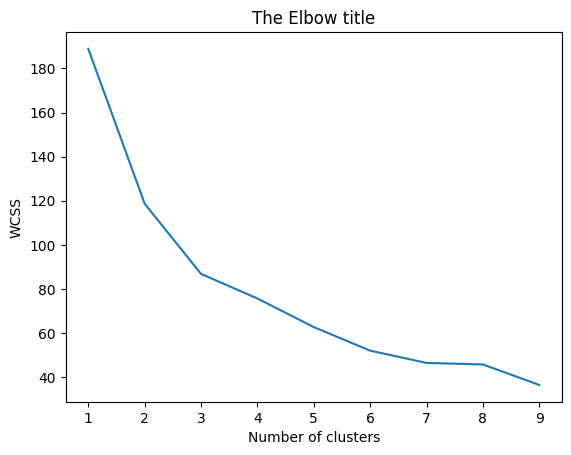

In [ ]:
#run kmeans with various number of k. evaluate no. of k based on the elbow plot

wcss=[]
max_k = 10

for i in range(1, max_k):
    kmeans = KMeans(n_clusters=i, n_init='auto')
    kmeans.fit(umap_embed_comments_array)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)
    number_clusters = range(1, max_k)

plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [ ]:
#run kmeans with no. of clusters you see fit the most
k = 3
kmeans = KMeans(n_clusters = k, n_init='auto')
kmeans.fit(umap_embed_comments_array)
df['KMeans ID'] = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#merge all reviews of each cluster into one big sentence
df_kmeans = pd.DataFrame(columns=["KMeans ID", "texts"])

for i in range(0, k):
    row = []
    row.append(i)
    row.append(df['sentence'][df['KMeans ID'] == i].to_string())
    df_kmeans.loc[len(df_kmeans)] = row

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_kmeans

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,KMeans ID,texts
0,0,2 ชัชชาติ สั่งการทุกเขต ! ตรวจสอบผับ เปิดร...
1,1,4 Highlight : อนาคตของสหภาพยุโรป!! รศ.ดร.ส...
2,2,0 FM 96.5 | ข่าวเด่น ประเด็นร้อน ช่วง Econ...


In [ ]:
#create regex compiler for removal of a character you don't want
special_characters = "/[!@#$%^&*']/g"
specialchar_pattern = re.compile(special_characters)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#create regex compiler for removal of any emoji
emoji_pattern = re.compile("["
u"\U0001F600-\U0001F64F" # emoticons
u"\U0001F300-\U0001F5FF" # symbols & pictographs
u"\U0001F680-\U0001F6FF" # transport & map symbols
u"\U0001F1E0-\U0001F1FF" # flags (iOS)
"]+", flags=re.UNICODE)

#create regex compiler for removal of digit
number_pattern = re.compile("[0-9]")
#create regex compiler for removal of white space
space_pattern = re.compile("\s+")
#create regex compiler for removal of .
dot_pattern = re.compile(r"\.+")
#create regex compiler for removal of \
backslash_pattern = re.compile(r"\\+")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:12: DeprecationWarning: invalid escape sequence '\s'
<>:12: DeprecationWarning: invalid escape sequence '\s'
<ipython-input-29-1b28a965a998>:12: DeprecationWarning: invalid escape sequence '\s'
  space_pattern = re.compile("\s+")


In [ ]:
#define a function to tokenize a sentence into words - you can define words you want to remove as well as new words for tokenization
stopwords = list(pythainlp.corpus.thai_stopwords())
removed_words = ['',' ','    ','\n', '(', ')', '?', '+', '--', '//', 'Highlight', '\u200b', 'ๆ(', '..', 'ๆๆๆๆ', 'ๆ', 'นะคะ', '-', '!', "['", "','", 'โรงแรม', 'ไทย',"'", ',', '[', 'ตรวจสอบ', 'ข่าว', 'ประเด็น', 'งาน', 'คลิป']
screening_words = stopwords + removed_words

# words = new_words.union(thai_words())
# custom_dictionary_trie = Trie(words)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#define a function to tokenize a sentence into words - you can define words you want to remove as well as new words for tokenization
def tokenize_to_list(sentence):
    merged = []
    words = pythainlp.word_tokenize(str(sentence), engine='deepcut')

    for word in words:
        if word not in screening_words:
            merged.append(word)
    return merged

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_kmeans['texts_tokenized'] = df_kmeans['texts'].apply(lambda x: tokenize_to_list(x))
df_kmeans['texts_count'] = df_kmeans['texts_tokenized'].apply(lambda x:collections.Counter(x).most_common())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


41/41 [==============================] - 1s 21ms/step


In [ ]:
df_kmeans

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,KMeans ID,texts,texts_tokenized,texts_count
0,0,ชัชชาติสั่งการทุกเขต!ตรวจสอบผับเปิดร้านอาหຂ່າວ...,"[ชัชชาติ, สั่งการ, เขต, ผับ, ร้าน, อาหຂ, ່, າ,...","[(|, 10), (สมัคร, 8), (າ, 6), (ร้าน, 4), (່, 4..."
1,1,Highlight:อนาคตของสหภาพยุโรป!!รศดรสมชายภเงินหา...,"[:, อนาคต, สหภาพยุโรป, รศด, รสม, ชายภ, เงินหาย...","[(;, 9), (เงิน, 7), (quot, 6), (&, 5), (|, 4),..."
2,2,FM|ข่าวเด่นประเด็นร้อนช่วงEconplusสรุปข่าวแมนย...,"[FM, |, เด่น, ร้อน, Econplus, สรุป, แมนยูล่าสุ...","[(|, 8), (เงิน, 3), (กรกฎาคม, 3), (ดาว, 3), (พ..."


In [ ]:
# show top key word of each cluster

top_n_words = 10
for i in range(0, len(df_kmeans)):
    print(f"Cluster ID : {i}\n")
    print(f"Most common words include : {list(df_kmeans['texts_count'][i])[:top_n_words]}\n")

Cluster ID : 0

Most common words include : [('|', 10), ('สมัคร', 8), ('າ', 6), ('ร้าน', 4), ('່', 4), ('เด็ด', 3), ('อะเมซิ่ง', 3), ('ลือ', 3), ('EP#taiyang#jploy#', 3), ('เจพลอย', 3)]

Cluster ID : 1

Most common words include : [(';', 9), ('เงิน', 7), ('quot', 6), ('&', 5), ('|', 4), ('จีน', 4), ('หุ้น', 4), ('รัฐบาล', 3), ('ท่องเที่ยว', 3), ('คน', 3)]

Cluster ID : 2

Most common words include : [('|', 8), ('เงิน', 3), ('กรกฎาคม', 3), ('ดาว', 3), ('พุธ', 3), ('๔', 3), ('ติดต่อ', 3), ('สื่อสาร', 3), ('ค้าขาย', 3), ('ย้าย', 3)]



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


 ## cosine similarity clustering

In [ ]:
#clustering using agglomorative clustering
knn_graph = kneighbors_graph(embed_comments_array, 5, include_self=False)
model = AgglomerativeClustering(
linkage="average", connectivity=knn_graph, n_clusters=10, metric="cosine")
model.fit(embed_comments_array)
df['Agglomerative ID'] = model.labels_

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#merge all reviews of each cluster into one big sentence
df_Agglomerative = pd.DataFrame(columns=["Agglomerative ID", "texts"])
for i in range(0, k):
    row = []
    row.append(i)
    row.append(str(df['sentence'][df['Agglomerative ID'] == i].tolist()))
    df_Agglomerative.loc[len(df_Agglomerative)] = row

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#clean and tokenize sentences. count the occurences of each word
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_Agglomerative['texts_tokenized'] = df_Agglomerative['texts'].apply(lambda x: tokenize_to_list(x))
df_Agglomerative['texts_count'] = df_Agglomerative['texts_tokenized'].apply(lambda x:
collections.Counter(x).most_common())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


4/4 [==============================] - 0s 15ms/step


In [ ]:
#show top keywords of each cluster
top_N_words = 10
for i in range(0, len(df_Agglomerative)):
    print(f"Cluster ID : {i}\n")
    print(f"Most common words include :{list(df_Agglomerative['texts_count'][i])[:top_N_words]}\n")

Cluster ID : 0

Most common words include :[('|', 56), ('ปี', 21), ('เงิน', 21), ('/', 19), ('"', 18), ('#', 17), ('สมัคร', 17), ('ดู', 16), ('สาย', 16), ('ท่องเที่ยว', 15)]

Cluster ID : 1

Most common words include :[('Clock', 2), ('ทำ', 1), ('กะ', 1), ('ดึก', 1), ('ร้าน', 1), ('สะดวก', 1), ('ซื้อ', 1), ('คน', 1), ('แปลก', 1), ('หน้า', 1)]

Cluster ID : 2

Most common words include :[('nan', 2), (']', 2), ('สวยงาม', 1), ('ดวง', 1), ('ตา', 1), ('สดใส', 1), ('พลายศรีณรงค์', 1), ('ตอน', 1), ('ร้าน', 1), ('ยาย', 1)]



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
